In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate
import Utils
import cv2
from facenet_pytorch import MTCNN, InceptionResnetV1
import gc

In [2]:
torch.cuda.memory_allocated()

0

In [3]:
data_root = '../../data/'

In [4]:
train_labels = pd.read_csv('train_data_clean.csv')
test_labels = pd.read_csv('test_data_clean.csv')
validation_labels = pd.read_csv('validation_data_clean.csv')
train_labels

,name,skin_tone,gender,age,is_face
0,TRAIN0001.png,0,0,1,False
1,TRAIN0002.png,5,1,0,True
2,TRAIN0005.png,1,1,0,False
3,TRAIN0007.png,1,0,1,True
4,TRAIN0009.png,7,0,1,False
...,...,...,...,...,...
6837,TRAIN9992.png,4,0,2,True
6838,TRAIN9993.png,1,1,1,True
6839,TRAIN9995.png,8,0,1,True
6840,TRAIN9998.png,4,1,1,False


In [5]:
def read_image(file):
    return np.array(Image.open(data_root+file).convert('RGB')).astype(np.float32)/255

(256, 256, 3)


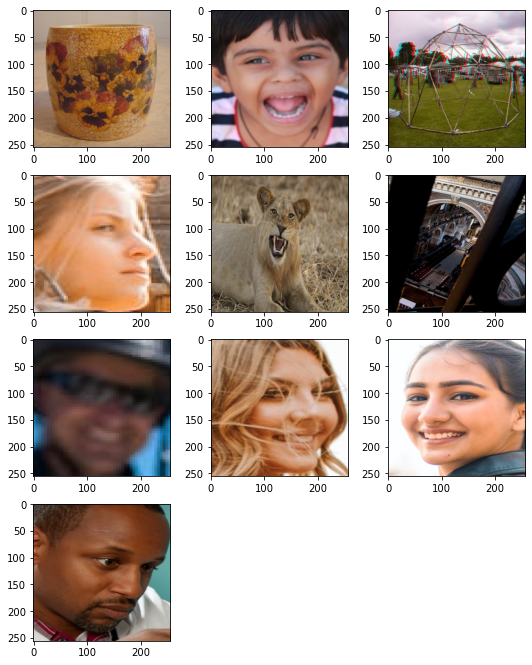

In [21]:
def resnet_preprocess(x): 
    #https://github.com/kentsommer/keras-inceptionV4/issues/5#issuecomment-287673694
    x = 2*(x-1) 
    return x

class Augmentor():
    
    def __init__(self,noise_sigma=.02):
        self.noise_sigma = noise_sigma
        
    def random_range(self,min_ratio = 0, max_ratio = .9):
        return max(min(max_ratio,1.5*np.random.random()), min_ratio)
    
    def random_crop(self,img):
        ratio = self.random_range(min_ratio=0.5)
        crop_size = [int(img.shape[0]*ratio), int(img.shape[1]*ratio)]
        assert crop_size[0] <= img.shape[0] and crop_size[1] <= img.shape[1], "Crop size should be less than image size"
        img = img.copy()
        w, h = img.shape[:2]
        x, y = np.random.randint(h-crop_size[0]), np.random.randint(w-crop_size[1])
        img = img[y:y+crop_size[0], x:x+crop_size[1]]
        return img
    
    def random_rotation(self,img, bg_patch=(5,5)):
        assert len(img.shape) <= 3, "Incorrect image shape"
        angle = (self.random_range(.25,.75)*360 - 180)
        rgb = len(img.shape) == 3
        if rgb:
            bg_color = np.mean(img[:bg_patch[0], :bg_patch[1], :], axis=(0,1))
        else:
            bg_color = np.mean(img[:bg_patch[0], :bg_patch[1]])
        img = rotate(img, angle,reshape=False)
        mask = [img <= 0, np.any(img <= 0, axis=-1)][rgb]
        img[mask] = bg_color
        return img
    
    def gaussian_noise(self,img, mean=0):
        img = img.copy()
        noise = (np.random.normal(mean, self.noise_sigma, img.shape)).astype(np.float16)
        mask_overflow_upper = img+noise >= 1
        mask_overflow_lower = img+noise < 0
        noise[mask_overflow_upper] = 1
        noise[mask_overflow_lower] = 0

        img += noise
        return img
    
    
    def color_shift(self,img):
        img = img.copy().astype(np.float16)
        for channel in [0,1,2]:
            img[channel] *= .5 + self.random_range(.1,.9)
        return img
    
    def augment_image(self,img,crop=True,rotate=True,noise=True,color_shift=False):
        shape = img.shape
        if img.ndim < 3 or shape[0] == 0 or shape[1] == 0 or shape[2] == 0:
            print('bad shape',shape)
        if crop:
            img = self.random_crop(img)
        if rotate:
            img = self.random_rotation(img)
        if noise:
            img = self.gaussian_noise(img)
        if color_shift:
            img = self.color_shift(img)
        img = cv2.resize(img,[shape[0],shape[1]])
        return img
    
    def augment_images(self,images,**kwargs):
        images = np.stack([self.augment_image(i,**kwargs) for i in images])
        return self.format_images(images)
    
    def format_images(self,images,normalize=False,whiten=False,resnet_normalize=False):
        images = images.astype(np.float32)
        if whiten:
            images = Utils.prewhiten(images)
        if normalize:
            images = Utils.l2_normalize(images)
        if resnet_normalize:
            images = resnet_preprocess(images)
        return images
   
def plot_selection(images,rows=20,columns=3):
    fig = plt.figure(figsize=(3*columns, 3*rows))
    # setting values to rows and column variables
    for i in range(rows*columns):
        if i >= len(images):
            return
        image = images[i]
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(image)
        
    return

augmentor = Augmentor()
ti = [read_image(n) for n in train_labels.iloc[0:10].name]
print(ti[0].shape)
plot_selection(ti)

In [22]:
torch.cuda.memory_allocated(torch.device('cuda'))

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)


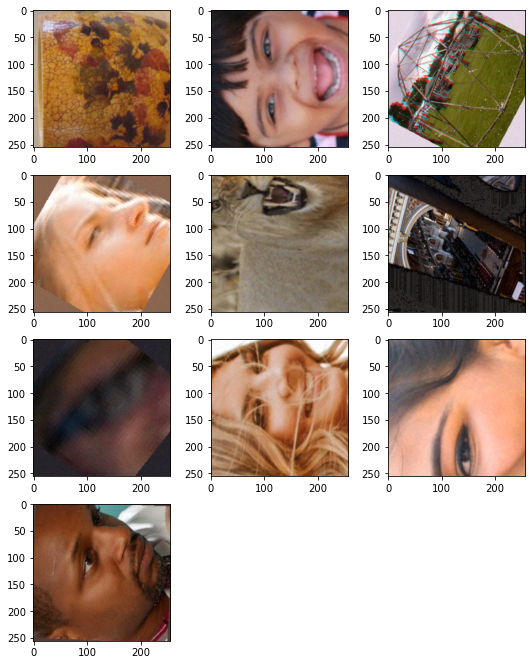

In [23]:
test_images = np.stack(ti)
test_images = augmentor.augment_images(test_images)
print(test_images[0].shape)
plot_selection(test_images)

In [24]:
del test_images
del ti
del augmentor
torch.cuda.memory_allocated(torch.device('cuda'))

0

In [25]:
def imgs_to_np(array):
    array = array.cpu().numpy()
    if array.ndim > 3:
        return np.moveaxis(array,1,-1)
    return np.moveaxis(array,0,-1)

def imgs_to_torch(array,convert=False):
    if array.ndim > 3:
        array = np.moveaxis(array,-1,1)
    else:
        array = np.moveaxis(array,-1,0)
    if convert:
        array = torch.from_numpy(array)
    return array


class FaceGeneratorIterator(torch.utils.data.Dataset):
    
    def __init__(self,df,root,
                 filter_nonfaces=True,
                 batch_size=1,
                 image_shape=(256,256,3),
                 labels=None,
                 regularize_labels=False,
                 validation_split=.2,
                 augment_images=True,
                 shuffle_on_epoch=True,
                 preload=False,
                 **kwargs):
        super(FaceGeneratorIterator,self).__init__()
        self.df = df.copy()
        
        if filter_nonfaces:
            self.df = df[df.is_face]
        
        self.image_shape = image_shape
        self.batch_size = 1
        self.root=root
        self.shuffle_on_epoch = shuffle_on_epoch
        self.labels = labels if (labels is not None) else ['skin_tone','age','gender']
        
        self.n_classes = {label: len(self.df[label].unique()) for label in self.labels}
        self.augmentor = Augmentor(**kwargs)
        if regularize_labels:
            self.df[self.labels] = self.df[self.labels].values/self.df[self.labels].max().values
            
        self.augment_images = augment_images
        
        if preload:
            self.df['image'] = self.df.name.apply(self.process_image_file)
        self.preloaded = preload
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    def __len__(self):
        return self.df.shape[0]
            
        
    def __getitem__(self,idx):
        subdf = self.df.iloc[idx]
        return self.process_files(subdf)
        
    def batch_subset(self,idx):
        start = idx*self.batch_size
        stop = start + self.batch_size
        subset = self.df.iloc[start:stop,:]
        return subset
    
    def shuffle(self):
        self.df = self.df.sample(frac=1)
    
    def process_image_file(self,i):
        image = read_image(i)
#         if np.any([image.shape[i] != self.image_shape[i] for i in range(3)]):
#             print(image.shape,i,self.image_shape)
#             image = cv2.resize(image,self.image_shape)
        return image
    
    def get_dataset(self):
        return self.process_files(self.df['name'])
    
    def process_files(self,subdf,augment_images=None,**kwargs):
        #will return a list of arrays [images, label1, label2, label3, etc]
        if self.preloaded:
            image = subdf['image']
        else:
            image = self.process_image_file(subdf['name'])
        augment_images = self.augment_images if augment_images is None else augment_images
        if augment_images:
            image = self.augmentor.augment_image(image,**kwargs)
        else:
            image = self.augmentor.format_images(image,**kwargs)
        #swaps axis to be batch x chanells x widht x height
        image = imgs_to_torch(image,convert=True)#.to(self.device) 
        labels = [subdf[label] for label in self.labels]
#         labels = [np.eye(self.n_classes[label],dtype=np.float16)[subdf[label]] for label in self.labels]
        output = [image, labels]
        return output

def FaceGenerator(labels,data_root,batch_size=150, **kwargs):
    #Is this legal?
    dataset = FaceGeneratorIterator(labels,data_root,**kwargs)
    return torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=dataset.shuffle_on_epoch)

train_dataset = FaceGenerator(train_labels,data_root)
val_dataset = FaceGenerator(validation_labels,data_root,augment_images=False)
[batch_x, batch_y] = next(iter(val_dataset))
[batch_x,batch_y[0]]

[tensor([[[[0.4078, 0.4039, 0.4000,  ..., 0.2353, 0.1686, 0.1020],
           [0.4078, 0.4039, 0.4039,  ..., 0.2784, 0.2353, 0.1961],
           [0.4196, 0.4157, 0.4078,  ..., 0.3373, 0.3451, 0.3490],
           ...,
           [0.4824, 0.4510, 0.4235,  ..., 0.1412, 0.1333, 0.1294],
           [0.4941, 0.4706, 0.4471,  ..., 0.1373, 0.1333, 0.1333],
           [0.5098, 0.4902, 0.4706,  ..., 0.1216, 0.1216, 0.1216]],
 
          [[0.4235, 0.4235, 0.4235,  ..., 0.2471, 0.1843, 0.1255],
           [0.4235, 0.4196, 0.4196,  ..., 0.2902, 0.2510, 0.2078],
           [0.4314, 0.4275, 0.4235,  ..., 0.3451, 0.3569, 0.3608],
           ...,
           [0.4314, 0.4000, 0.3725,  ..., 0.1059, 0.0980, 0.0941],
           [0.4431, 0.4196, 0.4000,  ..., 0.1020, 0.0980, 0.0980],
           [0.4588, 0.4392, 0.4196,  ..., 0.0863, 0.0863, 0.0863]],
 
          [[0.1255, 0.1294, 0.1333,  ..., 0.2118, 0.1490, 0.0863],
           [0.1333, 0.1294, 0.1294,  ..., 0.2549, 0.2118, 0.1725],
           [0.1412, 0.13

In [26]:
torch.cuda.memory_allocated(torch.device('cuda'))

0

In [ ]:
batch_x.shape

In [27]:
class ConvBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels,kernel_size):
        super().__init__()
        
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size, 1, 1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )

        self._init_weights()
        
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
            elif isinstance(m, torch.nn.BatchNorm2d):
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.nn.functional.avg_pool2d(x, 2)
        return x
    
class BasicCnnEmbedding(torch.nn.Module):
               
    def __init__(self,
                 filter_sizes = [8,8,8],
                 filter_kernel_sizes = [12,6,3],
                 hidden_sizes = [500],
                 embedding_size = 128,
                 initial_dropout = .01,
                 linear_dropout = .1,
                 try_cuda=True
                ):
        super().__init__()
        
        if try_cuda:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        else:
            self.device = torch.device('cpu')
            
        
        self.init_dropout = torch.nn.Dropout(initial_dropout).to(self.device)
        self.linear_dropout = torch.nn.Dropout(linear_dropout).to(self.device)
        
        convs = []
        curr_channels = 3
        for size,ksize in zip(filter_sizes,filter_kernel_sizes):
            layer = ConvBlock(curr_channels,size,ksize).to(self.device)
            curr_channels=size
            convs.append(layer)
        
        self.convs = convs
        
        self.flatten = torch.nn.Flatten()
        curr_size = 0
        self.fcs = []
        for size in hidden_sizes:
            lin = torch.nn.LazyLinear(size).to(self.device)
            relu = torch.nn.ReLU().to(self.device)
            norm = torch.nn.BatchNorm1d(size).to(self.device)
            dropout = torch.nn.Dropout(linear_dropout).to(self.device)
            block = torch.nn.Sequential(
                lin,relu,norm,dropout
            )
            self.fcs.append(block)
            
        self.linear = torch.nn.Linear(size,embedding_size).to(self.device)
        #literally this exists so the code works similar to inception feature extraction
        self.logits = torch.nn.Linear(embedding_size, 10).to(self.device) 

    def forward(self, x):
        x = x.to(self.device)
        x = self.init_dropout(x)
        for l in self.convs:
            x = l(x)
        x = self.linear_dropout(x)
        x = self.flatten(x)
        for l in self.fcs:
            x = l(x)
        x = self.linear(x)
        return x
 
torch.cuda.empty_cache()
test = BasicCnnEmbedding()
print(test(batch_x).shape)
del test
gc.collect()
torch.cuda.empty_cache();

/opt/conda/envs/rapids/lib/python3.8/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


torch.Size([150, 128])


In [28]:
class FacenetModel(torch.nn.Module):
    
    def __init__(self,
                 base_model = None,
                 hidden_dims = [200, 200],
                 st_dims = [200],
                 age_dims = [400],
                 gender_dims = [400],
                 embedding_dropout=.3,
                 st_dropout = .2,
                 age_dropout = .2,
                 gender_dropout = .2,
                 base_name='model',
                 fine_tune=False,
                    ):
        super(FacenetModel,self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        if base_model is None:
            base_model = InceptionResnetV1(pretrained='vggface2')
            base_name = 'facenet'
        base_model = base_model.to(self.device)
        if not fine_tune:
            for param in base_model.parameters():
                param.requires_grad = False
    
        self.base_model = base_model
        
        self.embedding_dropout = torch.nn.Dropout(p=embedding_dropout).to(self.device)
        curr_dim = base_model.logits.in_features
        self.hidden_layers = []
        for i,size in enumerate(hidden_dims):
            layer = torch.nn.Linear(curr_dim, size).to(self.device)
            curr_dim = size
            self.hidden_layers.append(layer)
            self.hidden_layers.append(torch.nn.ReLU().to(self.device))
        self.st_layers = self.make_output(curr_dim,st_dims,10,st_dropout)
        self.age_layers = self.make_output(curr_dim,age_dims,4,age_dropout)
        self.gender_layers = self.make_output(curr_dim,gender_dims,2,gender_dropout)
        
        name_string = base_name 
        if fine_tune:
            name_string += '_finetune'
        
        def add_dims(n,dims,prefix):
            for dim in dims:
                n += '_'+prefix+str(dim)
            return n
        
        
        name_string = add_dims(name_string,hidden_dims,'h')
        name_string = add_dims(name_string,st_dims,'st')
        
        name_string = add_dims(name_string,age_dims,'a')
        name_string = add_dims(name_string,gender_dims,'g')
                    
        name_string += '_ed' + str(embedding_dropout).replace('0.','')
        name_string += '_std' + str(st_dropout).replace('0.','')
        name_string += '_ad' + str(age_dropout).replace('0.','')
        name_string += '_gd' + str(gender_dropout).replace('0.','')
                               
        self.name_string = name_string
                               
    def make_output(self,start_size,sizes,n_classes,dropout):
        layers = []
        curr_size = start_size
        for size in sizes:
            layer = torch.nn.Linear(curr_size,size).to(self.device)
            curr_size = size
            layers.append(layer)
            layers.append(torch.nn.ReLU().to(self.device))
        if dropout > 0:
            layers.append(torch.nn.Dropout(p=dropout))
        layers.append(torch.nn.Linear(curr_size,n_classes).to(self.device))
        layers.append(torch.nn.ReLU().to(self.device))
        softmax = torch.nn.Softmax(dim=-1).to(self.device)
        layers.append(softmax)
        return layers
    
    def get_identifier(self):
        return self.name_string
    
    def apply_layers(self,x,layers):
        new_x = x
        for l in layers:
            new_x = l(new_x)
        return new_x
    
    def forward(self,x):
        x = x.to(self.device)
        x = self.base_model(x)
        x = self.embedding_dropout(x)
        for layer in self.hidden_layers:
            x = layer(x)
        
        x_st = self.apply_layers(x,self.st_layers)
        x_age = self.apply_layers(x,self.age_layers)
        x_gender = self.apply_layers(x,self.gender_layers)
        return [x_st,x_age,x_gender]
    

test = FacenetModel()
print(test.get_identifier())
test_y = test(batch_x)
print([y.shape for y in test_y])
del test
gc.collect()
torch.cuda.empty_cache();

facenet_h200_h200_st200_a400_g400_ed3_std2_ad2_gd2
[torch.Size([150, 10]), torch.Size([150, 4]), torch.Size([150, 2])]


/opt/conda/envs/rapids/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [29]:
test = FacenetModel(base_model = BasicCnnEmbedding(),fine_tune=False)
print(test.get_identifier())
test_y = test(batch_x)
print([y.shape for y in test_y])
del test
gc.collect()
torch.cuda.empty_cache();

model_h200_h200_st200_a400_g400_ed3_std2_ad2_gd2
[torch.Size([150, 10]), torch.Size([150, 4]), torch.Size([150, 2])]


In [ ]:
def categorical_accuracy(ypred,y):
    #y is index, ypred i s one hot like in loss functions
    predicted = torch.argmax(ypred,1).long()
    correct = torch.mean((y.long() == predicted).float())
    return correct

def save_train_history(model,history,root=''):
    model_name = model.get_identifier()
    
    df = pd.DataFrame(history)
    df['model'] = model_name
    string = root + 'results/history_' + model_name + '.csv'
    df.to_csv(string,index=False)
    return df, string

def train_model(model,
                train_loader,
                validation_loader,
                root,
                epochs=300,
                lr=1,
                patience = 20,
                loss_weights = [2,1,.5],
                save_path=None,
               ):
    if save_path is None:
        save_path = root + 'models/' + model.get_identifier()
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    format_y = lambda y: y.long().to(model.device)
    
    def train_epoch():
        running_loss = 0
        running_accuracy = [0,0,0]
        curr_loss = 0
        count = 0
        for i, [x_batch, y_batch] in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(x_batch)
            losses =[loss_fn(ypred.float(),format_y(y)) for y,ypred in zip(y_batch,outputs)]
            total_losses = loss_weights[0]*losses[0] + loss_weights[1]*losses[1] + loss_weights[2]*losses[2]
            total_losses.backward()
            optimizer.step()
            running_loss += total_losses.item()
            print('curr loss',total_losses.item(), 'step',i,' | ',end='\r')
            count += 1
            with torch.no_grad():
                for i,(y,ypred) in enumerate(zip(y_batch,outputs)):
                    accuracy = categorical_accuracy(ypred.float(),format_y(y))
                    running_accuracy[i] += accuracy.item()
        return running_loss/count, [a/count for a in running_accuracy]
    
    def val_epoch():
        with torch.no_grad():
            running_loss = 0
            running_accuracy = [0,0,0]
            count = 0
            for i, [x_batch, y_batch] in enumerate(validation_loader):
                outputs = model(x_batch)
                losses = sum([loss_fn(ypred.float(),format_y(y)) for y,ypred in zip(y_batch,outputs)])
                running_loss += losses.item()
                count += 1
                for i,(y,ypred) in enumerate(zip(y_batch, outputs)):
                    accuracy = categorical_accuracy(ypred.float(),format_y(y))
                    running_accuracy[i] += accuracy.item()
        return running_loss/count, [a/count for a in running_accuracy]
    model.train(True)
    
    best_val_loss = 100000
    steps_since_improvement = 0
    hist = []
    
    for epoch in range(epochs):
        print('epoch',epoch)
        model.train(True)
        avg_loss, avg_acc = train_epoch()
        print('train loss', avg_loss, 'train accuracy', avg_acc)
        model.train(False)
        val_loss, val_acc = val_epoch()
        print('val loss', val_loss, 'val accuracy', val_acc)
        torch.save(model.state_dict(), save_path + '_epoch' + str(epoch))
        if best_val_loss > val_loss:
            torch.save(model,save_path)
            best_val_loss = val_loss
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
        
        hist_entry = {
            'epoch': epoch,
            'train_loss': avg_loss,
            'train_acc':avg_acc,
            'val_loss':val_loss,
            'val_acc': val_acc,
            'lr': lr,
            'loss_weights': '_'.join([str(l) for l in loss_weights])
        }
        hist.append(hist_entry)
        save_train_history(model,hist,root=root)
        if steps_since_improvement > patience:
            break
    return model,hist

m,h = train_model(
    FacenetModel(base_model = BasicCnnEmbedding(),fine_tune=True),
    train_dataset,
    val_dataset,
    data_root,
)
del m
h

In [ ]:
m2,h2 = train_model(
    FacenetModel(base_model = BasicCnnEmbedding(),fine_tune=True),
    train_dataset,
    val_dataset,
    data_root,
)
del m2
h2

In [ ]:
torch.device('cuda')